# DS-GA 3001.009 Modeling Time Series Data

# Week 3 Kalman Filter

In [1]:
# Install PyKalman
# pip install pykalman
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from scipy.stats import multivariate_normal

# Data Visualiztion
def plot_kalman(x,y,nx,ny,kx=None,ky=None, plot_type="r-", label=None):
    """
    Plot the trajectory
    """
    fig = plt.figure()
    if kx is not None and ky is not None:
        plt.plot(x,y,'g-',nx,ny,'b.',kx,ky, plot_type)
        plt.plot(kx[0], ky[0], 'or')
        plt.plot(kx[-1], ky[-1], 'xr')
    else:
        plt.plot(x,y,'g-',nx,ny,'b.')

    plt.xlabel('X position')
    plt.ylabel('Y position')
    plt.title('Parabola')
    
    if kx is not None and ky is not None and label is not None:
        plt.legend(('true','measured', label))
    else:
        plt.legend(('true','measured'))
    
    return fig
    
def visualize_line_plot(data, xlabel, ylabel, title):
    """
    Function that visualizes a line plot
    """
    plt.plot(data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
def print_parameters(kf_model, need_params=None):
    """
    Function that prints out the parameters for a Kalman Filter
    @param - kf_model : the model object
    @param - need_params : a list of string
    """
    if need_params is None:
        need_params = ['transition_matrices', 'observation_matrices', 'transition_offsets', 
                  'observation_offsets', 'transition_covariance', 
                  'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
    for param in need_params: 
        print("{0} = {1}, shape = {2}\n".format(param, getattr(kf_model, param), getattr(kf_model, param).shape))

## Data

We will use a common physics problem with a twist. This example will involve firing a ball from a cannon at a 45-degree angle at a velocity of 100 units/sec. We have a camera that will record the ball's position ($pos_x, pos_y$) from the side every second. The positions measured from the camera ($\hat{pos}_x, \hat{pos}_y$) have significant measurement error. 

Latent Variable $z = [pos_x, pos_y, V_x, V_y]$

Observed Variable $x = [\hat{pos}_x, \hat{pos}_y, \hat{V}_x, \hat{V}_y]$

Reference: http://greg.czerniak.info/guides/kalman1/


In [2]:
# true (latent) trajectory
x = [0, 7.0710678118654755, 14.142135623730951, 21.213203435596427, 28.284271247461902, 35.35533905932738, 42.42640687119285, 49.49747468305833, 56.568542494923804, 63.63961030678928, 70.71067811865476, 77.78174593052023, 84.8528137423857, 91.92388155425118, 98.99494936611666, 106.06601717798213, 113.13708498984761, 120.20815280171308, 127.27922061357856, 134.35028842544403, 141.4213562373095, 148.49242404917499, 155.56349186104046, 162.63455967290594, 169.7056274847714, 176.7766952966369, 183.84776310850236, 190.91883092036784, 197.9898987322333, 205.0609665440988, 212.13203435596427, 219.20310216782974, 226.27416997969522, 233.3452377915607, 240.41630560342617, 247.48737341529164, 254.55844122715712, 261.6295090390226, 268.70057685088807, 275.77164466275354, 282.842712474619, 289.9137802864845, 296.98484809834997, 304.05591591021545, 311.1269837220809, 318.1980515339464, 325.2691193458119, 332.34018715767735, 339.4112549695428, 346.4823227814083, 353.5533905932738, 360.62445840513925, 367.6955262170047, 374.7665940288702, 381.8376618407357, 388.90872965260115, 395.9797974644666, 403.0508652763321, 410.1219330881976, 417.19300090006305, 424.26406871192853, 431.335136523794, 438.4062043356595, 445.47727214752496, 452.54833995939043, 459.6194077712559, 466.6904755831214, 473.76154339498686, 480.83261120685233, 487.9036790187178, 494.9747468305833, 502.04581464244876, 509.11688245431424, 516.1879502661798, 523.2590180780453, 530.3300858899108, 537.4011537017764, 544.4722215136419, 551.5432893255074, 558.614357137373, 565.6854249492385, 572.756492761104, 579.8275605729696, 586.8986283848351, 593.9696961967006, 601.0407640085662, 608.1118318204317, 615.1828996322972, 622.2539674441628, 629.3250352560283, 636.3961030678938, 643.4671708797594, 650.5382386916249, 657.6093065034904, 664.680374315356, 671.7514421272215, 678.822509939087, 685.8935777509525, 692.9646455628181, 700.0357133746836, 707.1067811865491, 714.1778489984147, 721.2489168102802, 728.3199846221457, 735.3910524340113, 742.4621202458768, 749.5331880577423, 756.6042558696079, 763.6753236814734, 770.7463914933389, 777.8174593052045, 784.88852711707, 791.9595949289355, 799.0306627408011, 806.1017305526666, 813.1727983645321, 820.2438661763977, 827.3149339882632, 834.3860018001287, 841.4570696119943, 848.5281374238598, 855.5992052357253, 862.6702730475909, 869.7413408594564, 876.8124086713219, 883.8834764831875, 890.954544295053, 898.0256121069185, 905.096679918784, 912.1677477306496, 919.2388155425151, 926.3098833543806, 933.3809511662462, 940.4520189781117, 947.5230867899772, 954.5941546018428, 961.6652224137083, 968.7362902255738, 975.8073580374394, 982.8784258493049, 989.9494936611704, 997.020561473036, 1004.0916292849015, 1011.162697096767, 1018.2337649086326, 1025.304832720498, 1032.3759005323636, 1039.4469683442292, 1046.5180361560947, 1053.5891039679602]
y = [0, 6.972967811865475, 13.847835623730951, 20.624603435596427, 27.303271247461904, 33.88383905932738, 40.366306871192855, 46.750674683058335, 53.036942494923814, 59.22511030678929, 65.31517811865477, 71.30714593052025, 77.20101374238573, 82.9967815542512, 88.69444936611667, 94.29401717798214, 99.79548498984762, 105.1988528017131, 110.50412061357858, 115.71128842544405, 120.82035623730953, 125.831324049175, 130.74419186104046, 135.55895967290593, 140.2756274847714, 144.89419529663687, 149.41466310850234, 153.83703092036782, 158.1612987322333, 162.38746654409877, 166.51553435596423, 170.5455021678297, 174.4773699796952, 178.31113779156067, 182.04680560342615, 185.68437341529162, 189.2238412271571, 192.66520903902256, 196.00847685088803, 199.25364466275352, 202.40071247461898, 205.44968028648447, 208.40054809834993, 211.2533159102154, 214.00798372208087, 216.66455153394634, 219.22301934581182, 221.6833871576773, 224.04565496954277, 226.30982278140823, 228.4758905932737, 230.54385840513916, 232.51372621700463, 234.3854940288701, 236.15916184073558, 237.83472965260106, 239.41219746446652, 240.891565276332, 242.27283308819744, 243.5560009000629, 244.7410687119284, 245.82803652379386, 246.81690433565933, 247.7076721475248, 248.50033995939026, 249.19490777125574, 249.7913755831212, 250.2897433949867, 250.69001120685215, 250.99217901871762, 251.19624683058308, 251.30221464244855, 251.31008245431403, 251.2198502661795, 251.03151807804497, 250.74508588991043, 250.3605537017759, 249.87792151364138, 249.29718932550685, 248.61835713737233, 247.8414249492378, 246.96639276110326, 245.99326057296872, 244.9220283848342, 243.75269619669967, 242.48526400856514, 241.11973182043062, 239.65609963229608, 238.09436744416155, 236.434535256027, 234.67660306789247, 232.82057087975795, 230.86643869162342, 228.8142065034889, 226.66387431535435, 224.41544212721982, 222.0689099390853, 219.62427775095077, 217.08154556281625, 214.4407133746817, 211.70178118654718, 208.86474899841264, 205.9296168102781, 202.8963846221436, 199.76505243400905, 196.53562024587453, 193.20808805773999, 189.78245586960546, 186.2587236814709, 182.63689149333638, 178.91695930520186, 175.09892711706732, 171.1827949289328, 167.16856274079825, 163.05623055266372, 158.84579836452917, 154.53726617639464, 150.13063398826012, 145.62590180012558, 141.02306961199105, 136.3221374238565, 131.52310523572197, 126.62597304758744, 121.6307408594529, 116.53740867131836, 111.34597648318382, 106.05644429504929, 100.66881210691476, 95.18307991878022, 89.59924773064569, 83.91731554251115, 78.1372833543766, 72.25915116624206, 66.28291897810752, 60.208586789972976, 54.03615460183844, 47.7656224137039, 41.39699022556936, 34.930258037434825, 28.365425849300287, 21.70249366116575, 14.941461473031213, 8.082329284896677, 1.1250970967621399, 0, 0, 0, 0, 0, 0]
# observed (noisy) trajectory
nx = [-55.891836789860065, -8.619869715037396, 42.294527931003934, -19.282331191905236, 15.680071645375804, 69.254448170858, 89.33867920263654, 28.666899505436437, 15.757974418210033, 56.95110872477952, 119.04246497636771, 61.62441951678902, 39.29934181599181, 138.7343828583496, 96.51963541398798, 117.86368373222598, 67.09014965331974, 135.85134345741767, 121.0077151824216, 162.7264612213607, 118.09485999718689, 161.3851623148557, 153.61801317724127, 138.04480650773763, 136.57674149045124, 186.64610285009547, 190.4353428154434, 187.08542653674456, 179.34131017012345, 203.60872317676595, 230.44206917637285, 200.5851735051386, 188.42133059532134, 232.7400979104982, 225.30478119739485, 267.2756895668691, 203.85938526332433, 283.3059183111086, 243.60174631799248, 255.04877235779932, 298.9707904316639, 269.8143043032952, 252.32059784738885, 270.55891357039184, 326.59494694358125, 327.44121025500505, 323.8788885796068, 342.8998939277302, 284.8080106831782, 308.30384319438355, 331.602751441996, 369.37448486134394, 326.7534721557288, 432.3093248477627, 406.1850938379638, 368.3192718477926, 417.1242042573391, 376.80066629284977, 328.070404259563, 453.310935909394, 428.1929004969645, 387.52306470654355, 455.6351576860221, 455.4826886731417, 425.56091814116144, 464.50297459897234, 473.83062985528187, 508.0018220206407, 538.1473047813328, 474.1768111706383, 487.07340663957956, 513.8908741322764, 504.02223767836966, 533.5666187993398, 475.84484473401085, 540.774394416208, 532.450138885039, 596.1973293350309, 616.4286469911126, 571.2502050174375, 490.3795627036758, 595.1192153241902, 565.0843289032891, 565.8861393244426, 535.3381668961649, 554.494293004607, 614.8000696382559, 610.6070255172268, 595.1137023505969, 655.8549550650116, 652.1364054115451, 627.0822281047308, 684.8459180830978, 627.4287726057535, 646.4232572721058, 649.8096669791199, 713.6046684169744, 698.0070989016643, 670.0057860355556, 652.4216425995312, 676.1048509824369, 716.7538322065785, 755.4377489437768, 721.282075245216, 710.0104845231749, 727.173927219191, 728.0409503769652, 765.4419988280144, 714.4351907609439, 780.131570018707, 788.9558247395082, 826.4452430146916, 753.5313843631791, 772.7596204233874, 816.0768173822422, 827.2783309068349, 813.59413380325, 868.0575409685421, 819.297427582733, 842.4657416222495, 886.9452546786852, 848.0810151733698, 840.3562201041242, 814.5238953430719, 909.815296516205, 932.007124918161, 920.1521325921302, 894.7381254084694, 898.8234101267616, 916.4237616794475, 909.8509105807899, 959.775584291071, 913.833379291161, 928.6214973254758, 1023.4704479915798, 972.8771173177097, 929.6006265282693, 922.4096220769878, 965.6499344468668, 1004.1043594740715, 998.0662730766439, 990.0011025721882, 1003.1192778598809, 958.761271165956, 1014.5513285266792, 1102.4832378048654, 1009.1078733361437, 1045.4004495002835, 969.8376930757283, 1023.9209108407833]
ny = [23.580712916615695, -45.62854499965875, -48.454167220387774, 57.63682593281395, 24.958737249448383, -75.44208650853136, 26.41512511354887, 49.05382536552557, 119.5753276811912, -8.883926248926471, 68.61653476275158, 73.70930930561039, 73.33534997643633, 136.46569500850046, 84.65157143902442, 116.75120295727146, 64.03491049317876, 83.17721636270467, 67.48086927886698, 114.0031414926982, 126.98883515540626, 141.94465033561954, 121.4932906407089, 82.17340012376054, 171.20366262408706, 140.86199817266035, 156.15800993843771, 205.18083992090502, 201.76590950501574, 120.00689401909713, 127.22410828056267, 174.70956131509004, 148.2365665374927, 145.51245102878624, 176.1302017047836, 185.20777488199408, 162.6018916409635, 201.10110170021446, 151.66614689027648, 219.42574853381643, 146.53360660925895, 172.0394862006801, 205.89640027275198, 228.51657142871176, 233.09734143057807, 196.9051845126125, 217.61161160052148, 176.2328457551726, 232.91906774032418, 194.05143658995405, 212.54799704705485, 237.58982040493999, 248.06683550872324, 194.1313367493484, 234.10914455708777, 260.9183828690817, 241.38145360438665, 234.18839201094602, 298.7156304059963, 229.37945966087958, 150.42222803196753, 276.519008189128, 254.65250291987843, 276.76968161072347, 236.66608705629918, 252.7664567709944, 300.2402250565306, 265.79289722004, 206.71833433177704, 230.80064422085013, 282.21969317504124, 278.7505962073449, 264.65420420047275, 269.1414531557679, 300.78849412505315, 290.40324997636577, 228.4884963762248, 255.06136385539696, 224.79305441888243, 190.58455654967446, 236.9316778500026, 237.1642802017231, 197.04061689021333, 243.08831859311766, 298.69768812880136, 253.7179052734462, 214.9052914066147, 206.4070815355148, 236.37282969584498, 256.212452196932, 227.34374697096126, 245.96074526312518, 228.28624137197147, 293.80645840131524, 223.3350286792413, 189.11490296131603, 173.18703394374444, 224.19402293984098, 201.5893028879243, 196.71922438575157, 191.29908495274748, 181.68302817527396, 189.5274869883944, 223.8798616894293, 174.03835368022368, 225.8029667750153, 243.32963834156004, 161.72407829159798, 195.87525096604634, 128.4947824255718, 125.03030538969553, 178.94162993285272, 178.69848164174897, 163.25298077414635, 120.14847616048053, 156.19072198888165, 111.86292881870203, 123.53293860987199, 149.80320169931565, 137.76193157426053, 123.56291412411045, 122.88482052173731, 169.4024959581775, 113.64420024942245, 75.95358936834089, 112.73548045966685, 89.77944981081296, 132.3832257220346, 118.28500887622158, 41.80194386445528, 72.97395976865779, 27.564707182159275, 41.944224628335874, 35.26542969310611, 43.441159853568024, 48.784181310168904, 52.156577913216324, 25.654795701109094, 61.6957571291634, 50.6070208231052, 71.1942426060467, 85.42901900020982, -23.71494481685784, 36.536539251335405, 21.97545137095642, -16.352874522717297, -20.656788404218812, -27.959598326260984, 10.981406961205966, -12.446671920156849]
data = np.array([nx,ny]).T

(150, 2)


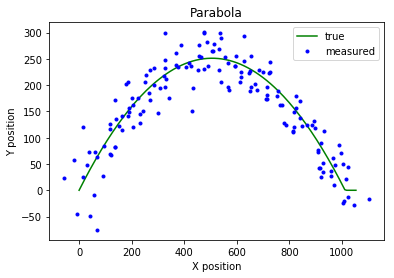

In [3]:
print(data.shape)
_ = plot_kalman(x,y,nx,ny);

## Review on Gaussian marginal and conditional distributions

Assume

$$z=[x^Ty^T]^T$$

$$z=\begin{bmatrix}x \\y\end{bmatrix}\sim N\left(\begin{bmatrix}a \\b\end{bmatrix}, \begin{bmatrix}A & C \\C^T & B\end{bmatrix}\right)$$

then the marginal distributions are

$$x\sim N(a, A)$$
$$y\sim N(b,B)$$

and the conditional distributions are

$$x|y \sim N(a+CB^{-1}(y-b), A-CB^{-1}C^T)$$
$$y|x \sim N(b+C^TA^{-1}(x-a), B-C^TA^{-1}C)$$

*important take away: given the joint Gaussian distribution we can derive the conditionals*

## Review on Linear Dynamical System

Latent variable: $$z_n = Az_{n-1}+w$$

Observed variable: $$x_n = Cz_{n}+v$$

Gaussian noise terms:
$$w\sim N(0, \Gamma)$$
$$v\sim N(0, \Sigma)$$
$$z_0\sim N(\mu_0, \Gamma_0)$$

As a consequence, $z_n$, $x_n$ and their joint distributions are Gaussian so we can easily compute the marginals and conditionals.

<br>
<img src='img/LDS.svg', width = 300, height=300>

*right now $n$ depends only on what was one time step back $n-1$ (Markov chain)*


Given the graphical model of the LDS we can write out the joint probability for both temporal sequences:

$$P(\mathbf{z}, \mathbf{x}) = P(z_0)\prod_{n=1...N} P(z_n|z_{n-1}) \prod_{n=0...N} P(x_n|z_{n})$$

*all probabilities are implicitely conditioned on the parameters of the model*

## Kalman

We want to infer the latent variable $z_n$ given the observed variable $x_n$.

$$P(z_n|x_1, ..., x_n, x_{n+1}, ..., x_N)\sim N(\hat{\mu_n}, \hat{V_n})$$

### Forward: Filtering
obtain estimates of latent by running the filtering from $n=0,....N$ 

#### prediction given latent space parameters
<br>
<img src='img/LDS_latent.svg', width = 110, height=90>


$$z_n^{pred}\sim N(\mu_n^{pred},V_n^{pred})$$

$$\mu_n^{pred}=A\mu_{n-1}$$

*this is the prediction for $z_n$ obtained simply by taking the expected value of $z_{n-1}$ and projecting it forward one step using the transition probability matrix $A$*

$$V_n^{pred}=AV_{n-1}A^T+\Gamma$$
*same for the covariance taking into account the noise covariance $\Gamma$*

#### correction (innovation) from observation
<br>
<img src='img/LDS_observed.svg', width = 40, height=80>

project to observational space:
$$x_n^{pred}\sim N(C\mu_n^{pred}, CV_n^{pred}C^T+\Sigma)$$

correct prediction by actual data:
$$z_n^{innov}\sim N(\mu_n^{innov}, V_n^{innov})$$

$$\mu_n^{innov}=\mu_n^{pred}+K_n(x_n-C\mu_n^{pred})$$

$$V_n^{innov}=(I-K_nC)V_n^{pred}$$

Kalman gain matrix: 
$$K_n=V_n^{pred}C^T(CV_n^{pred}C^T+\Sigma)^{-1}$$

*we use the latent-only prediction to project it to the observational space and compute a correction proportional to the error $x_n-CAz_{n-1}$ between prediction and data, coefficient of this correction is the Kalman gain matrix*

<br>
<img src='img/Kfilter_Bishop.png', width = 600, height=600>
from Bishop (2006), chapter 13.3

*if measurement noise is small and dynamics are fast -> estimation will depend mostly on observed data*

#### Kalman Filter to predict true (latent) trajectory from observed variable using Pykalman API

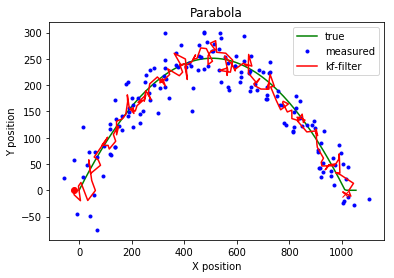

In [4]:
kf = KalmanFilter(n_dim_state=data.shape[1], n_dim_obs=data.shape[1])
# fit the model (use EM algorithm to estimate the parameters, we will not worry about this for now)
kf.em(data, n_iter=6)
# Kalman filtering
filtered_state_means, filtered_state_covariances = kf.filter(data)
fig = plot_kalman(x,y,nx,ny, filtered_state_means[:,0], filtered_state_means[:,1], "r-", "kf-filter")


### Backward: Smoothing

<br>
<img src='img/LDS_smooth.svg', width = 110, height=100>

obtain estimates by propagating from $x_n$ back to $x_1$ using results of forward pass ($\mu_n^{innov}, V_n^{innov}, V_n^{pred}$)


$$N(z_n|\mu_n^{smooth}, V_n^{smooth})$$

$$\mu_n^{smooth}=\mu_n^{innov}+J_n(\mu_{n+1}^{smooth}-A\mu_n^{innov})$$

$$V_n^{smooth}=V_n^{innov}+J_n(V_{n+1}^{smooth}-V_{n+1}^{pred})J_n^T$$

$$J_N=V_n^{innov}A^T (V_{n+1}^{pred})^{-1}$$

This gives us the final estimate for $z_n$.

$$\hat{\mu_n}=\mu_n^{smooth}$$
$$\hat{V_n}=V_n^{smooth}$$

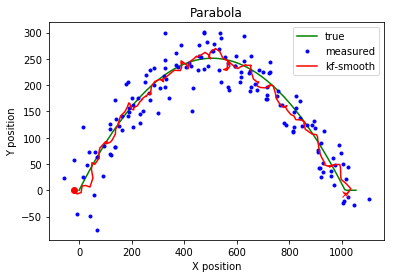

In [5]:
# Kalman smoothing
smoothed_state_means, smoothed_state_covariances = kf.smooth(data)
fig = plot_kalman(x,y,nx,ny, smoothed_state_means[:,0], smoothed_state_means[:,1], "r-", "kf-smooth")

# Kalman Filter Implementation

In this part of the exercise, you will implement the Kalman filter. Specifically, you need to implement the following method:

- filter: assume learned parameters, perform the forward calculation
- smooth: assume learned parameters, perform both the forward and backward calculation

In [6]:
class MyKalmanFilter:
    """
    Class that implements the Kalman Filter
    """
    def __init__(self, n_dim_state=2, n_dim_obs=2):
        """
        @param n_dim_state: dimension of the laten variables
        @param n_dim_obs: dimension of the observed variables
        """
        self.n_dim_state = n_dim_state
        self.n_dim_obs = n_dim_obs
        self.transition_matrices = np.eye(n_dim_state)
        self.transition_offsets = np.zeros(n_dim_state) # you can ignore this one, not used
        self.transition_covariance = np.eye(n_dim_state)
        self.observation_matrices = np.eye(n_dim_obs, n_dim_state)
        self.observation_covariance = np.eye(n_dim_obs)
        self.observation_offsets = np.zeros(n_dim_obs) # you can ignore this one, not used
        self.initial_state_mean = np.zeros(n_dim_state)
        self.initial_state_covariance = np.eye(n_dim_state)
        
        
    def filter(self, X):
        """
        Method that performs Kalman filtering
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @output: filtered_state_means: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: filtered_state_covariances: a numpy 3D array whose dimension is [n_example, self.n_dim_state, self.n_dim_state]
        """
        
        # validate inputs
        n_example, observed_dim = X.shape
        assert observed_dim==self.n_dim_obs
        
        # create holders for outputs
        filtered_state_means = np.zeros( (n_example, self.n_dim_state) )
        filtered_state_covariances = np.zeros( (n_example, self.n_dim_state, self.n_dim_state) )
        
        # TODO: implement filtering
        
        # the first state mean and state covar is the initial epectation
        filtered_state_means[0] = self.initial_state_mean
        filtered_state_covariances[0] = self.initial_state_covariance
        
        # initialize internal variables
        current_state_mean = self.initial_state_mean.copy()
        current_state_covar = self.initial_state_covariance.copy()
        self.p_n_list = np.zeros((n_example, self.n_dim_obs, self.n_dim_obs))
        for i in range(1, n_example):
            current_observed_data = X[i,:]
            # run a single step forward filter
            # prediction step
            predicted_state_mean = np.dot(self.transition_matrices, current_state_mean)
            predicted_state_cov = np.matmul(np.matmul(self.transition_matrices, current_state_covar),np.transpose(self.transition_matrices)) + self.transition_covariance
            # observation step
            innovation = current_observed_data - np.dot(self.observation_matrices, predicted_state_mean)
            innovation_covariance = np.matmul(np.matmul(self.observation_matrices, predicted_state_cov), np.transpose(self.observation_matrices)) + self.observation_covariance
            # update step
            kalman_gain = np.matmul(np.matmul(predicted_state_cov, np.transpose(self.observation_matrices)), np.linalg.inv(innovation_covariance))
            current_state_mean = predicted_state_mean + np.dot(kalman_gain, innovation)
            current_state_covar = np.matmul( (np.eye(current_state_covar.shape[0])- 
                                              np.matmul(kalman_gain,self.observation_matrices)), predicted_state_cov)
            # populate holders
            filtered_state_means[i, :] = current_state_mean
            filtered_state_covariances[i, :, :] = current_state_covar
            self.p_n_list[i, :, :] = predicted_state_cov
        return filtered_state_means, filtered_state_covariances
    
    def smooth(self, X):
        """
        Method that performs the Kalman Smoothing
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @output: smoothed_state_means: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: smoothed_state_covariances: a numpy 3D array whose dimension is [n_example, self.n_dim_state, self.n_dim_state]
        """
        # validate inputs
        n_example, observed_dim = X.shape
        assert observed_dim==self.n_dim_obs
        
        # init for EM
        self.j_n = []
        
        # run the forward path
        mu_list, v_list = self.filter(X)
        
        # create holders for outputs
        smoothed_state_means = np.zeros( (n_example, self.n_dim_state) )
        smoothed_state_covariances = np.zeros( (n_example, self.n_dim_state, self.n_dim_state) )
        
        # last time step doesn't need to be updated
        smoothed_state_means[-1, :] = mu_list[-1, :]
        smoothed_state_covariances[-1, :, :] = v_list[-1, :, :]
        
        # run the backward path
        # it's zero-indexed and we don't need to update the last elements
        for i in range(n_example-2, -1, -1):
            # used to store intermediate results 
            p_i = np.matmul(np.matmul(self.transition_matrices, v_list[i,:,:]), self.transition_matrices.T) + self.transition_covariance
            j_i = np.matmul(np.matmul(v_list[i,:,:], self.transition_matrices.T), np.linalg.inv(p_i))
            
            # calculate mu_bar and v_bar
            current_smoothed_mean = mu_list[i, :] + np.matmul(j_i, (smoothed_state_means[i+1, :] - np.matmul(self.transition_matrices, mu_list[i, :])))
            current_smoothed_covar = v_list[i,:] + np.matmul(np.matmul(j_i, ( smoothed_state_covariances[i+1, :, :] - p_i)), j_i.T)
            # propagate the holders
            smoothed_state_means[i, :] = current_smoothed_mean
            smoothed_state_covariances[i, :, :] = current_smoothed_covar
            # note that j_n is REVERSELY propagated from N-2 to 0 (zero-indexed)
            self.j_n.append(j_i)
        # add the last j_n
        p_N = np.matmul(np.matmul(self.transition_matrices, v_list[-1,:,:]), np.linalg.inv(self.transition_matrices)) + self.transition_covariance
        j_N = np.matmul(np.matmul(v_list[-1,:,:], self.transition_matrices.T), np.linalg.inv(p_N))
        self.j_n = list(reversed(self.j_n))
        self.j_n.append(j_N)
            
        return smoothed_state_means, smoothed_state_covariances    
    
    def import_param(self, kf_model):
        """
        Method that copies parameters from a trained Kalman Model
        @param kf_model: a Pykalman object
        """
        need_params = ['transition_matrices', 'observation_matrices', 'transition_offsets', 
                  'observation_offsets', 'transition_covariance', 
                  'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
        for param in need_params:
            setattr(self, param, getattr(kf_model, param))
        

### Filtering

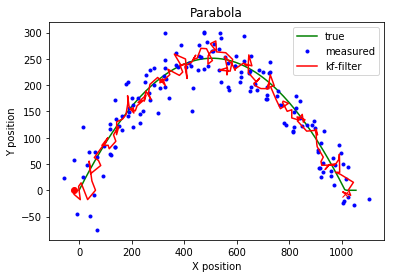

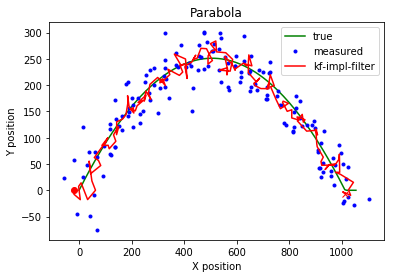

In [7]:
kf = KalmanFilter(n_dim_state=data.shape[1], n_dim_obs=data.shape[1])
kf.em(data)
my_kf = MyKalmanFilter(n_dim_state=data.shape[1], n_dim_obs=data.shape[1])
my_kf.import_param(kf)
filtered_state_means, filtered_state_covariances = kf.filter(data)
filtered_state_means_impl, filtered_state_covariances_impl = my_kf.filter(data)
_ = plot_kalman(x,y,nx,ny, filtered_state_means[:,0], filtered_state_means[:,1], "r-", "kf-filter")
_ = plot_kalman(x,y,nx,ny, filtered_state_means_impl[:,0], filtered_state_means_impl[:,1], "r-", "kf-impl-filter")

### Smoothing

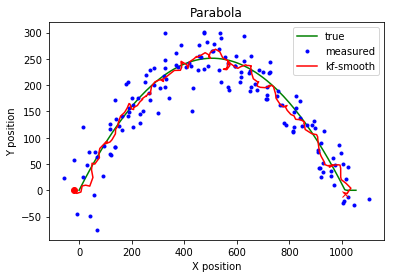

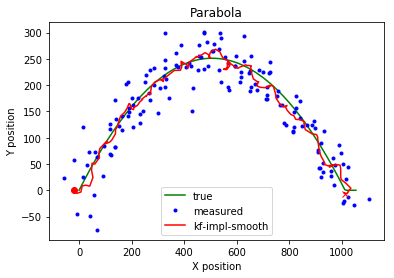

In [8]:
kf = KalmanFilter(n_dim_state=data.shape[1], n_dim_obs=data.shape[1])
kf.em(data)
my_kf = MyKalmanFilter(n_dim_state=data.shape[1], n_dim_obs=data.shape[1])
my_kf.import_param(kf)
smoothed_state_means, smoothed_state_covariances = kf.smooth(data)
smoothed_state_means_impl, smoothed_state_covariances_impl = my_kf.smooth(data)
fig = plot_kalman(x,y,nx,ny, smoothed_state_means[:,0], smoothed_state_means[:,1], "r-", "kf-smooth")
fig = plot_kalman(x,y,nx,ny, smoothed_state_means_impl[:,0], smoothed_state_means_impl[:,1], "r-", "kf-impl-smooth")

### Please turn in the code before 02/10/2019 3:00 pm. Please name your notebook netid.ipynb.

### Your work will be evaluated based on the code and plots. You don't need to write down your answers to these questions in the text blocks. 